In [1]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
import numpy as np
import pandas as pandas
from sklearn.model_selection import KFold

import time, sys
from IPython.display import clear_output

%matplotlib inline
%matplotlib widget

import matplotlib as matplotlib
import matplotlib.pyplot as pyplot
from matplotlib.pyplot import figure
from matplotlib.pyplot import legend as Legend
from matplotlib.widgets import Button as mButton
from matplotlib.image import *
import matplotlib.widgets as m_widgets
import matplotlib.animation
import ipywidgets as widgets
from ipywidgets import interactive as interactive
from IPython.display import display
from tensorflow.keras.models import load_model
import random
from numpy.random import rand
import ipympl as ipl
from sklearn.manifold import TSNE
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler

# Handwritten Number Recognition GUI

In [2]:
# Loads the trained Keras model
model = load_model('numClassificationModel.h5')

2022-02-06 18:16:51.016694: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Loads the history from the Keras model
history=np.load('modelTrainHistory.npy',allow_pickle='TRUE').item()

In [4]:
# Load and sort the MNIST data
(trainData, trainLabels), (testData, testLabels) = mnist.load_data()

In [5]:
def reshapeImgs(testData, testLabels, trainData, trainLabels):
    
    trainData = trainData.reshape(trainData.shape[0], 28, 28, 1)
    testData = testData.reshape(testData.shape[0], 28, 28, 1)
    
    imgShape = (28, 28, 1)
    trainLabels = keras.utils.to_categorical(trainLabels)
    testLabels = keras.utils.to_categorical(testLabels)
    
    trainData = trainData.astype('float32')
    testData = testData.astype('float32')
    
    trainData /= 255
    testData /= 255

In [6]:
reshapeImgs(testData, testLabels, trainData, trainLabels)

In [7]:
# Upon click of sample data image, the number is predicted using the Keras model.
def selectImg(testData, index):
    
    image = testData[index].reshape(1, 28, 28, 1)
    result = model.predict(image)
    return np.argmax(result), max(result)

In [8]:
# Shows the model's accuracy and loss percentages
def showAccLossPercent(testData, testLabels, trainData, trainLabels, rateId):
    
    trainData = trainData.reshape(trainData.shape[0], 28, 28, 1)
    testData = testData.reshape(testData.shape[0], 28, 28, 1)
    
    imgShape = (28, 28, 1)

    trainLabels = keras.utils.to_categorical(trainLabels)
    testLabels = keras.utils.to_categorical(testLabels)
    
    trainData = trainData.astype('float32')
    testData = testData.astype('float32')
    
    trainData /= 255
    testData /= 255
  
    rate = model.evaluate(testData, testLabels, verbose=0)
    
    if(rateId == 0):
        return rate[0]*100
    else:
        return rate[1]*100

In [9]:
class numImg(object):
    
    # Stores references to figures.
    def __init__(self, fig, index, testData):
        
        # implements the PyPlot figure class
        self.fig = fig
 
        # indicates the index of the image within the MNIST dataset
        self.index = index
        
        # creates a copy of the MNIST test dataset
        self.testData = testData
      
        # access current axes
        self.ax = pyplot.gca()
        
        # creates button to reset prediction output
        self.resetButton = widgets.Button(description="Reset", fontsize=16)
        
        # creates function to reset prediction output
        self.resetButton.on_click(self.resetButtonClicked)
        
        # displays label above the number image
        self.label = self.ax.set_title("Click to see prediction", fontsize=18)
        
        # mpl_connect captures the click and triggers prediction output
        self.cid = self.fig.canvas.mpl_connect('button_press_event', self.imageClicked)
        
    # Upon click of sample data image, number in image will be predicted and output   
    def imageClicked(self, event):
        
        self.ax.set_title(selectImg(testData, self.index)[0], fontsize=18)
    
    # Upon click of reset button, the model's prediction of a sample data image will be cleared.
    def resetButtonClicked(self, event):
        
        self.ax.set_title("Click to see prediction", fontsize=18)
        
    def show(self):
        
        pyplot.show()
        self.fig.show()

In [10]:
# Creates a "LOADING" bar which will track function completion
def createProgressBar():
    
    progressBar = widgets.IntProgress(value=0,
    min=0,
    max=10,
    step=1,
    description='One moment please...',
    bar_style='', 
    orientation='horizontal')
    count = 0
    
    return progressBar

In [11]:
# implements the previously defined progress bar
def loadProgressBar(progressBar, rateId):
    
    count=0
    while count <= 3:
        progressBar.value += 1
        time.sleep(.1)
        count+=1

    score = showAccLossPercent(testData, testLabels, trainData, trainLabels, rateId)

    while count <= 10:
        # triggers incrementing of the progress bar load status
        progressBar.value += 1 
        time.sleep(.4)
        count += 1
        
    return score

In [12]:
# Calculates and displays model rate of loss

def getLossRate(event, button, vbox):  
    
    percentLabel = widgets.Label(value='')
    totalTestedLabel = widgets.Label(value='')
    totalLossLabel = widgets.Label(value='')
    
    progressBar = createProgressBar()
    
    if(len(button.description) > 6):
        
        vbox.children += (progressBar, percentLabel, totalTestedLabel, totalLossLabel)
        
        score = loadProgressBar(progressBar, 0)
        totalTested = len(testData)
        totalLoss = int(len(testData) * (score/100))
        
        percentLabel.value = str(score)+' % loss'
        totalTestedLabel.value = "Images Tested: "+str(totalTested)
        totalLossLabel.value = "Incorrect Predictions: "+str(totalLoss)
        
        progressBar.value = 10
        time.sleep(.2)
        progressBar.layout.visibility = 'hidden'
        
        
    else:
        button.description = "Click to Show Loss Rate"
        vbox.children=[]

In [13]:
# Calculates and displays model rate of accuracy
def getAccRate(event, button, vbox):
    
    percentLabel = widgets.Label(value='')
    totalTestedLabel = widgets.Label(value='')
    totalCorrectLabel = widgets.Label(value='')
    
    progressBar = createProgressBar()
    
    if(len(button.description) > 6):
        
        vbox.children += (progressBar, percentLabel, totalTestedLabel, totalCorrectLabel) 
        score = loadProgressBar(progressBar, 1)
        
        totalCorrect = int(len(testData)*(score/100))
        totalTested = len(testData)
        
        percentLabel.value = str(score)+ "% accuracy"
        totalTestedLabel.value = "Images Tested: "+str(totalTested)
        totalCorrectLabel.value = "Accurate Predictions: "+str(totalCorrect)
        
        progressBar.value=10
        time.sleep(.2)
        progressBar.layout.visibility = 'hidden'

    else:
        button.description = "Click to Show Accuracy Rate"
        vbox.children=[]

In [14]:
# Predictive Element
# 10 random image samples from dataset. 
# When an image is clicked, model predicts.

def getImgs():
    
    hboxList = []
    hboxList2 = []
    
    numSamples = 4
    
    indexes = random.sample(range(len(testData)), numSamples)

    for i in range(len(indexes)):
        output = widgets.Output()
        with output:
            fig = pyplot.figure()
        pyplot.imshow(testData[indexes[i]], cmap=pyplot.get_cmap('gray'), picker=True)
        newTest = numImg(fig, indexes[i], testData)
        fig.canvas.toolbar_position = 'bottom'
            
        hbox = widgets.HBox([newTest.resetButton, output])
        hboxList.append(hbox)
        
        if (i+1)%2 == 0:
            n_hbox = widgets.HBox([])
            for k in range(i-1, i+1):
                n_hbox.children += (hboxList[k],)
            hboxList2.append(n_hbox)
            
    vbox = widgets.VBox([])
    
    for box in range(0, len(hboxList2)):
        vbox.children += (hboxList2[box],)
    return vbox

In [15]:
# creates button for calculating and displaying loss

def showLossButton():
    
    style = {"description_width": "initial"}

    lossButton = widgets.Button(description="Loss Rate", style=style)
    
    lossButton.layout.height = "60px"
    lossButton.layout.width = "25%"
    
    lossButton.style.button_color="AliceBlue"
    
    resVbox = widgets.VBox([])

    lossHbox = widgets.HBox([lossButton, resVbox])
    lossButton.on_click(lambda event: getLossRate("button_press_event", lossButton, resVbox))
    
    return lossHbox

In [16]:
# creates button for calculating and displaying accuracy

def showAccButton():
        
    style = {'description_width': 'initial'}

    accButton = widgets.Button(description="Accuracy Rate", style=style)
    
    accButton.layout.height = '60px'
    accButton.layout.width = '25%'
    
    accButton.style.button_color="AliceBlue"
    
    resVbox = widgets.VBox([])
    
    accHbox = widgets.HBox([accButton, resVbox])
    accButton.on_click(lambda event: getAccRate('button_press_event', accButton, resVbox))
    
    return accHbox

In [17]:
# Descriptive element
# Plots the frequency of numbers in the dataset

def plotNumFreq():
    
    nums = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    
    numFreq = [0]*10
    
    for label in testLabels:
        numFreq[label]+=1
    output = widgets.Output()
    
    with output:
        fig = pyplot.figure()
   
    pyplot.gca().set_title("Frequency by Number")
    pyplot.gca().set_xlabel("Number")
    pyplot.gca().set_ylabel("Frequency")
    pyplot.gca().set_yticks(np.arange(0, 1140, 100))
    
    pyplot.bar(nums, numFreq, color=['b', 'g', 'r', 'c', 
                                          'm', 'y', 'k', 'gray', 'olive', 'pink'])

    lNumFreq = widgets.Label(value="Plotting digit frequency...")
    
    vbox=widgets.VBox((output,))
    
    return vbox

In [18]:
# plots the accuracy rate of the model

def plotAccAnalysis():
    
    output=widgets.Output()
    with output:
        fig = pyplot.figure()
    pyplot.gca().set_title("Classification Accuracy Analysis")
    pyplot.plot(history['accuracy'], color='k', label="Training Accuracy")
    pyplot.plot(history['val_accuracy'], color='m', label="Validation Accuracy")
    pyplot.xlabel("Epoch")
    pyplot.ylabel("Accuracy Rate")
    pyplot.legend()
    
    vbox = widgets.VBox((output,))
    return vbox

In [19]:
# plots model loss rate

def plotLossAnalysis():

    output=widgets.Output()
    with output:
        fig = pyplot.figure()
    pyplot.gca().set_title("Cross Entropy Loss Analysis")
    loss=pyplot.plot(history['loss'], color='b', label="Training Loss")
    val_loss=pyplot.plot(history['val_loss'], color='g', label="Validation Loss")
    pyplot.xlabel("Epoch")
    pyplot.ylabel("Loss Rate")
    pyplot.legend()

    vbox = widgets.VBox((output,))
    return vbox

In [20]:
# Shows progress bar to indicate loading

def showProgBar1(progressBar, description):
        
    style={'description_width': 'initial'}

    progressBar.description=description
    progressBar.style=style
    
    display(progressBar)
    
    count=0
    while count <= 3:
        progressBar.value += 1
        time.sleep(.1)
        count+=1
    return progressBar

In [21]:
# Completes display of progress bar once loading completes

def showProgBar2(progressBar):
        
    count=3
    while count <= 10:
        progressBar.value += 1 
        time.sleep(.4)
        count += 1

    progressBar.value = 10
    time.sleep(.3)
    progressBar.layout.visibility='hidden'

In [22]:
def startApp():
    
    pyplot.close('all')    
    
    style={'description_width': 'initial'}   
    
    progressBar1 = createProgressBar()
    
    showProgBar1(progressBar1, "Loading...")  
    
    showProgBar2(progressBar1)
    
    datasetLabel = widgets.Label(value= "Click images to see model prediction.")
    
    # container for dataset sample images
    imgsVbox = getImgs()
    
    # displays accuracy button
    accHbox = showAccButton()
    
    # displays losses button
    lossHbox = showLossButton()
    
    # VBox holds accuracy and loss buttons
    rateVbox = widgets.VBox([accHbox, lossHbox])
    
    display(rateVbox)
    
    # container for imgsVbox above and the datasetLabel
    datasetVbox = widgets.VBox([datasetLabel, imgsVbox]) 

    # displays the datasetVbox above
    display(datasetVbox)
    
    # number frequency bar graph
    numFreqBox = plotNumFreq()
 
    # displays num freq bar graph
    display(numFreqBox)
    
    acc_analysis_box = plotAccAnalysis()
    display(acc_analysis_box)
    
    loss_analysis_box = plotLossAnalysis()
    display(loss_analysis_box)

IntProgress(value=0, description='Loading...', max=10, style=ProgressStyle(description_width='initial'))

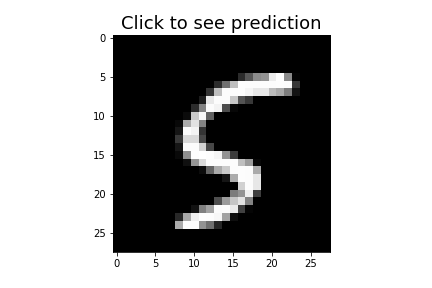

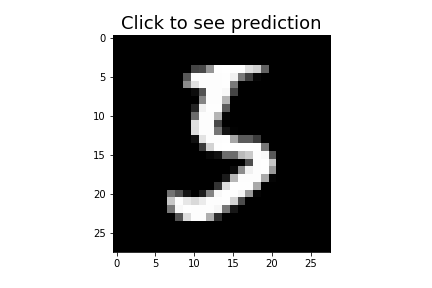

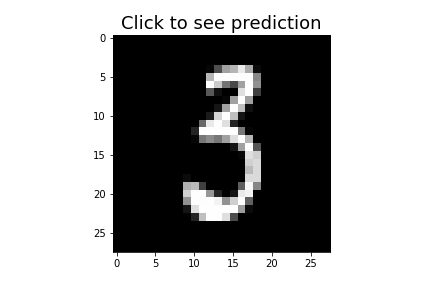

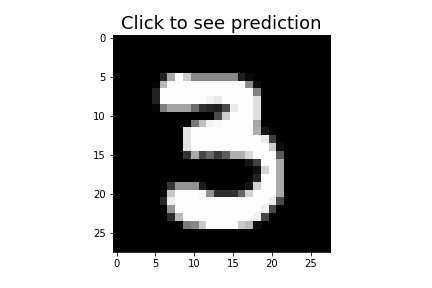

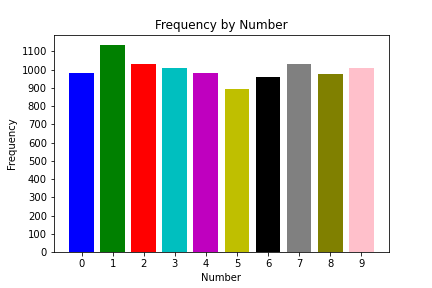

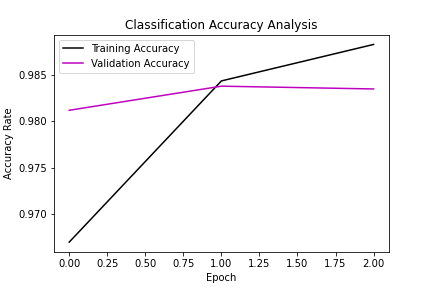

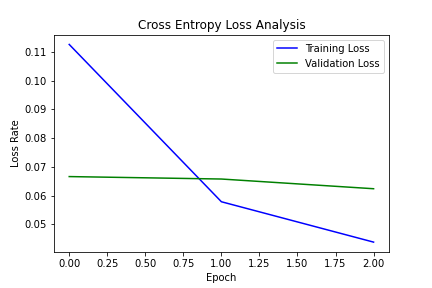

In [23]:
# creates a clean slate before starting the app
pyplot.close('all')
startApp()